# CRF not helpful
view **Efficient Patch-Wise Semantic Segmentation for Large-Scale Remote Sensing Images** for detail

In [1]:
import numpy as np
from skimage.io import imread, imsave
from skimage.color import gray2rgb
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, create_pairwise_gaussian

"""
Function which returns the labelled image after applying CRF

"""

#Original_image = Image which has to labelled
#Annotated image = Which has been labelled by some technique( FCN in this case)
#Output_image = The final output image after applying CRF
#Use_2d = boolean variable 
#if use_2d = True specialised 2D fucntions will be applied
#else Generic functions will be applied

def crf(original_image, annotated_image,output_image, use_2d = True):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(annotated_image.shape)<3):
        annotated_image = gray2rgb(annotated_image)
        
    #Converting the annotations RGB color to single 32 bit integer
    annotated_label = annotated_image[:,:,0] + (annotated_image[:,:,1]<<8) + (annotated_image[:,:,2]<<16)
    
    # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)
    
    #Creating a mapping back to 32 bit colors
    colorize = np.empty((len(colors), 3), np.uint8)
    colorize[:,0] = (colors & 0x0000FF)
    colorize[:,1] = (colors & 0x00FF00) >> 8
    colorize[:,2] = (colors & 0xFF0000) >> 16
    
    #Gives no of class labels in the annotated image
    n_labels = len(set(labels.flat)) 
    
#     print("No of labels in the Image are ")
#     print(n_labels)
    
    
    #Setting up the CRF model
    if use_2d :
        d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

        # get unary potentials (neg log probability)
        U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
        d.setUnaryEnergy(U)

        # This adds the color-independent term, features are the locations only.
        d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                          normalization=dcrf.NORMALIZE_SYMMETRIC)

        # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
        d.addPairwiseBilateral(sxy=(80, 80), srgb=(13, 13, 13), rgbim=original_image,
                           compat=10,
                           kernel=dcrf.DIAG_KERNEL,
                           normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for 5 steps 
    Q = d.inference(5)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    # Convert the MAP (labels) back to the corresponding colors and save the image.
    # Note that there is no "unknown" here anymore, no matter what we had at first.
    MAP = colorize[MAP,:]
    return MAP.reshape(original_image.shape)

In [43]:
import numpy as np
import pydensecrf.densecrf as dcrf
import pydensecrf.utils as utils

MAX_ITER = 10
POS_W = 3
POS_XY_STD = 1
Bi_W = 4
Bi_XY_STD = 67
Bi_RGB_STD = 3


def dense_crf(img, output_probs):
    c = output_probs.shape[0]
    h = output_probs.shape[1]
    w = output_probs.shape[2]

    U = utils.unary_from_softmax(output_probs)
    U = np.ascontiguousarray(U)

    img = np.ascontiguousarray(img)

    d = dcrf.DenseCRF2D(w, h, c)
    d.setUnaryEnergy(U)
    d.addPairwiseGaussian(sxy=POS_XY_STD, compat=POS_W)
    d.addPairwiseBilateral(sxy=Bi_XY_STD, srgb=Bi_RGB_STD, rgbim=img, compat=Bi_W)

    Q = d.inference(MAX_ITER)
    Q = np.array(Q).reshape((c, h, w))
    return Q

In [10]:
import os
import sys
work_dir=os.path.expanduser('~/git/torchseg')
if work_dir not in sys.path:
    sys.path.insert(0,work_dir)
    
from utils.metrics import get_fmeasure
from utils.config import load_config
from utils.notebook import get_model_and_dataset
from models.motionseg.motion_utils import get_parser,get_default_config,get_dataset
from models.motionseg.motion_utils import get_other_config
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm,trange
import torch
import fire
import os
import cv2
import matplotlib.pyplot as plt
import glob
from utils.disc_tools import show_images
from models.motionseg.motion_benchmark import get_save_path

config_file='motion_filter_flow/FBMS/task119_all'
output_root_path='output'
use_crf=True
if not os.path.exists(config_file):
    pattern=os.path.expanduser('~/tmp/logs/motion/**/config.txt')
    config_files=glob.glob(pattern,recursive=True)
    config_files=[f for f in config_files if f.find(config_file)>=0]
    assert len(config_files)>0
    config_file=config_files[0]
    print(config_file)

model,dataset_loaders,normer=get_model_and_dataset(config_file)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()

/home/yzbx/tmp/logs/motion/motion_filter_flow/FBMS/task119_all/2019-04-18___13-06-20/config.txt
train dataset size 353
val dataset size 367
val_path dataset size 367
no checkpoint file given, auto find /home/yzbx/tmp/logs/motion/motion_filter_flow/FBMS/task119_all/2019-04-18___13-06-20/model-last-30.pkl


motion_filter_flow(
  (main_backbone): motion_backbone(
    (prefix_net): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)

val_path dataset size 367
before crf: 0.7791216305305119, after crf: 0.6056464908619823


TypeError: Invalid dimensions for image data

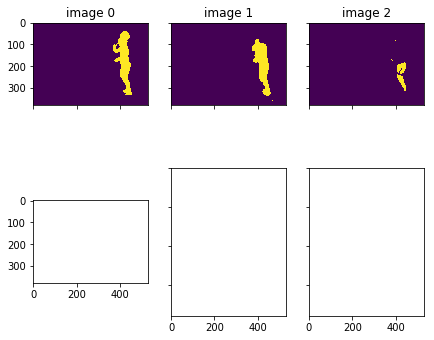

In [45]:
from utils.disc_tools import show_images
use_crf=True
config=model.config
split='val_path'
dataset=get_dataset(config,split)
sum_f=sum_crf_f=sum_densecrf_f=0
for data_dict in dataset_loaders[split]:
    assert isinstance(data_dict,dict),'type is {}'.format(data_dict)
    images = [torch.autograd.Variable(img.to(device).float()) for img in data_dict['images']]
    gt_paths=data_dict['gt_path']
    assert len(gt_paths)==1
    save_path=get_save_path(gt_paths[0],config.root_path,os.path.join(output_root_path,config.dataset,config.note))

    outputs=model.forward(images)
    shape=data_dict['shape']
    origin_mask=F.interpolate(outputs['masks'][0], size=shape[0:2],mode='nearest')
    os.makedirs(os.path.dirname(save_path),exist_ok=True)
    
    img_path=dataset.get_frames(gt_paths[0])[0]
    origin_img=cv2.imread(img_path)
    gt_img=np.squeeze(data_dict['gt'].data.cpu().numpy())
    if use_crf:
        raw_pred=origin_mask.data.cpu().numpy()[0,:,:,:]
        save_img=np.squeeze(np.argmax(origin_mask.data.cpu().numpy(),axis=1)).astype(np.uint8)*255
        n_labels = len(np.unique(save_img))
        if n_labels>1:
            crf_save_img=crf(origin_img,save_img,save_path)
            crf_save_img=rgb2gray(crf_save_img)
            
            crf_pred_img=dense_crf(origin_img,raw_pred)
            crf_pred_img=np.argmax(crf_pred_img,axis=0)
        else:
            crf_pred_img=crf_save_img=save_img
        
        sum_f+=get_fmeasure(gt=gt_img,pred=save_img)
        sum_crf_f+=get_fmeasure(gt=gt_img,pred=crf_save_img)
        sum_densecrf_f+=get_fmeasure(gt=gt_img,pred=crf_pred_img)
    else:
        save_img=np.squeeze(np.argmax(origin_mask.data.cpu().numpy(),axis=1)).astype(np.uint8)*255

N=len(dataset)
print('before crf: {}, after crf: {}, after dense crf {}'.format(sum_f/N,sum_crf_f/N,sum_densecrf_f/N))
if use_crf:
    show_images([gt_img,save_img,crf_save_img,crf_pred_img,origin_img])
else:
    show_images([gt_img,save_img,origin_img])

before crf: 0.7791216305305119, after crf: 0.6056464908619823, after dense crf 0.2515651964707969


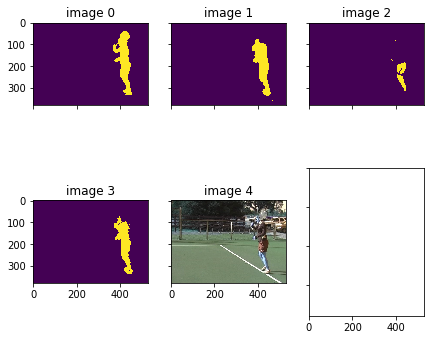

In [50]:
N=len(dataset)
print('before crf: {}, after crf: {}, after dense crf {}'.format(sum_f/N,sum_crf_f/N,sum_densecrf_f/N))
dense_img=np.argmax(crf_pred_img,axis=0)
if use_crf:
    show_images([gt_img,save_img,crf_save_img,dense_img,origin_img])
else:
    show_images([gt_img,save_img,origin_img])